# Lyell Above Twin Bridges 19/20 Solinst Levelogger Post Processing
Joe Ammatelli | May 14, 2022

This notebook documents the steps taken to arrive at the barocorrected stage data for a given site (starting from the raw Solinst Levelogger data). In particular, this notebook faciliates the following postprocessing/quality control steps:
1. Inspection of the raw data
2. Confirmation that the data is in UTC
3. Trimming of the data to the times when it was actively deployed (in the water)
4. Standardizing of the time series to such that all samples fall on the hour or half-hour
5. Barocorrection (compensation for atmospheric pressure in unvented Solinst Levelogger data)
6. Flagging of Ice Jams
7. Identification and sensor shifts

Once all steps have been completed, a .csv file with the following quantities will be generated for each contiguous segment (period in the time series where there are no obvious sensor shifts):
* Date and time (UTC)
* raw pressure, cm
* barocorrected pressure, cm
* water temperature, degrees C
* discharge flag

Author of Template and Underlying Code: Joe Ammatelli | (jamma@uw.edu) | May 2022

## Import Relevant Libaries
**Analyst TODO**: Nothing

In [1]:
import os
import sys
import seaborn as sns

sys.path.insert(0, os.path.abspath(os.path.join('..', '..', 'src')))

import config
import level_baro_utils
import log_utils

sys.path.remove(os.path.abspath(os.path.join('..', '..', 'src')))

## Specify Site Information
**Analyst TODO**:
* assign an integer representing the site to the variable `sitecode`. Mappings are as follows (follows from upstream to downstream):
    * 0 : Lyell Below Maclure
    * 1 : Lyell Above Twin Bridges
    * 2 : Dana Fork at Bug Camp
    * 3 : Tuolumne River at Highway 120
    * 4 : Budd Creek
    * 5 : Delaney Above PCT
* assign a string (format 'YYYY') representing the collection year of the data to the variable `collection_year`
* assign a string (format 'YY/YY') representing the span in years of the data to the variable `span`

These input parameters are used to automatically retrieve the correct raw data, populate the correct log file, label any plots with relevant site descriptors, and automatically write output with descriptive names. 

In [2]:
# example: site is Budd Creek, data was collected in 2019, and the data spanned 2018 and 2019
# sitecode = 4
# collection_year = '2019'
# span = '18/19'

sitecode = 1
collection_year = '2020'
span = '19/20'

## Set Plot Settings and Compile Site Information
**Analyst TODO**: Nothing

In [3]:
sns.set_theme()

In [4]:
site_info = {'sitecode':sitecode,
             'site':config.SITE_LONGNAME[sitecode],
             'collection_year':collection_year,
             'span':span}

## Load and Inspect Raw Data
**Analyst TODO**: Examine the tabular data and time series plots. Confirm all desired data is present. Note any glaring irregularities in the time series. 

In [5]:
level_path = os.path.join('..', 'data', 'normalized_raw', f'lvl_{config.SITE_SHORTNAME[sitecode]}_{collection_year}.csv')

In [6]:
level_df = level_baro_utils.load_normalized_solinst_data(level_path)
level_df.head()

,lvl_cm,temp_C
Date_Time,,
2019-08-08 08:16:08,758.15,12.010
2019-08-08 08:46:08,759.15,12.868
2019-08-08 09:16:08,759.05,11.941
2019-08-08 09:46:08,809.80,11.212
2019-08-08 10:16:08,809.73,11.075


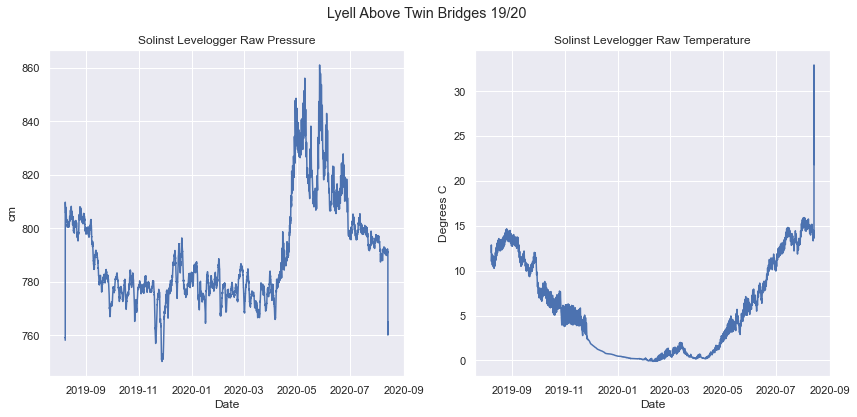

In [7]:
level_baro_utils.plot_solinst_pressure_temp(level_df, site_info)

## Verify UTC
**Analyst TODO**: 
* Choose small range (1-3 days) to observe temperature swings. If possible, choose a range when stream is dry (as determined by inspecting time lapse imagery and field notes).
* Assign a string representing the start date (format 'YYYY-MM_DD') to the `tz_start_date` variable
* Assign a string representing the end date (format 'YYYY-MM_DD') to the `tz_end_date` variable
* Run the next two cells and confirm temperature peaks algin with expected time of day in UTC
* Conclude as to whether the data is in UTC and write a comment in the string assigned ot `utc_note`. E.g:
```
utc_note = 'Temp peaks around 23:00 (4:00PM local time). Conclude data is in UTC'
```

In [8]:
# example
# tz_start_date = '2018-9-26'
# tz_end_date = '2018-9-27'

tz_start_date = '2019-9-23'
tz_end_date = '2019-9-25'

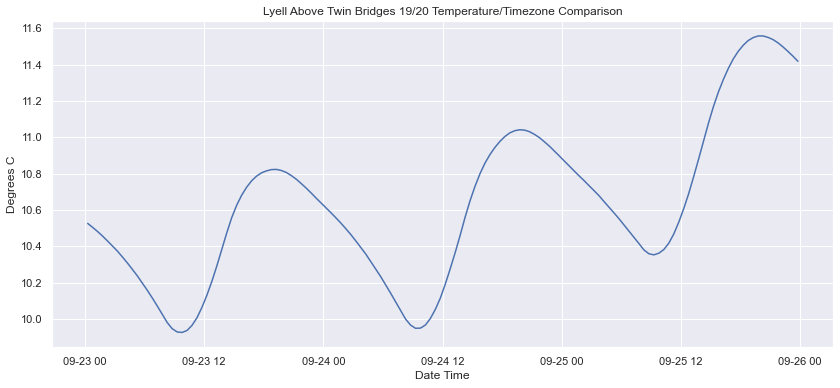

In [9]:
level_baro_utils.plot_temp_interval(level_df, tz_start_date, tz_end_date, site_info, label='Temperature/Timezone Comparison')

In [10]:
utc_note = 'Temp peaks around 22:00 (22:00 - 7 = 3:00). Conclude data is in UTC'

In [11]:
print(utc_note)

Temp peaks around 23:00 (23:00 - 7 = 4:00). Conclude data is in UTC


## Trim
**Analyst TODO**: 
* assign a string (format 'YYYY-MM-DD HH:MM') representing the date and time (UTC) the sensor was deployed in the water to the variable `insert_datetime` (reasonable to begin with times recorded in field notes)
* assign a string (format 'YYYY-MM-DD HH:MM') representing the date and time (UTC) the sensor was removed from the water to the variable `remove_datetime` (reasonable to begin with times recorded in field notes)
* inspect the resultant plots and adjust `insert_datetime` and `remove_datetime` as needed to capture the true period the sensor was in the water
* **Note**: In most cases there is a pronounced, sudden change in both temperature and pressure when the sensor is inserted/removed. Use this to guide tuning. 

In [12]:
# example
# insert_datetime = '2018-08-1 17:20'
# remove_datetime = '2019-08-14 16:00'

insert_datetime = '2019-08-8 10:33'
remove_datetime = '2020-08-13 10:38'

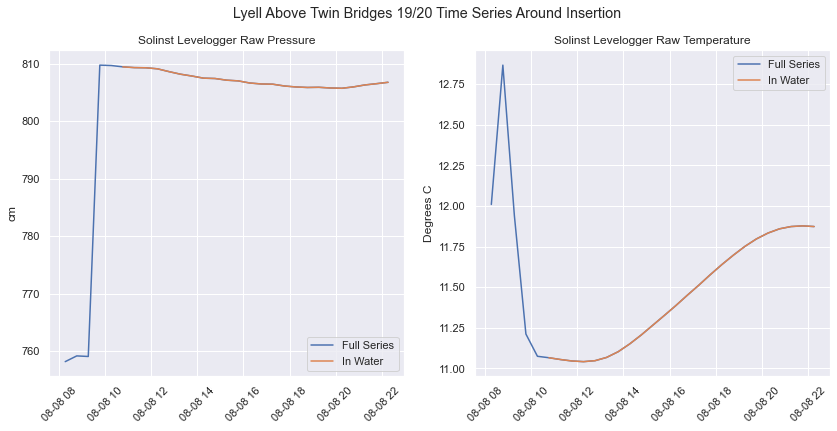

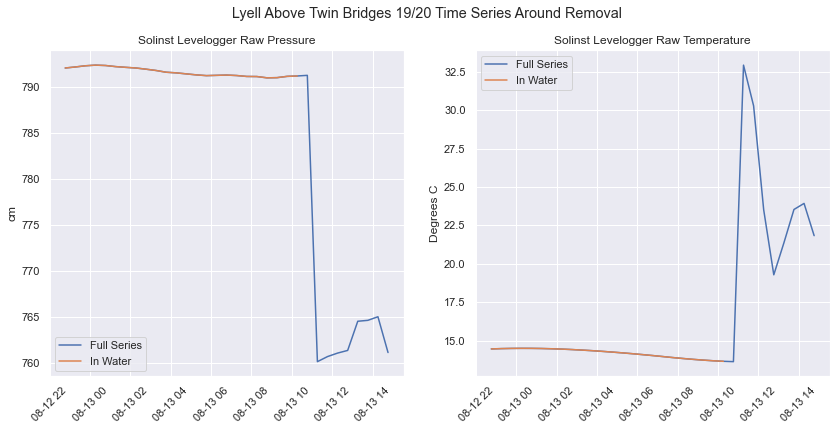

In [13]:
level_baro_utils.plot_in_water(level_df, insert_datetime, remove_datetime, site_info)

## Trim Time Series
**Analyst TODO**: Observe the resultant plot and confirm the data was trimmed properly. 

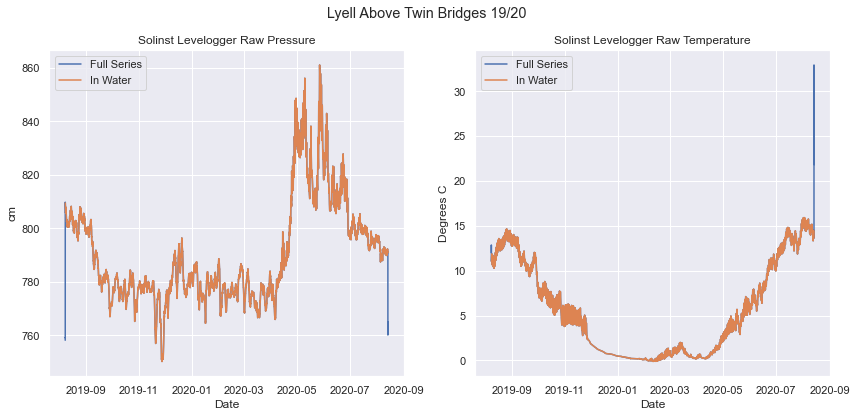

In [14]:
level_trim_df = level_baro_utils.trim_df(level_df, insert_datetime, remove_datetime, site_info)

## Load Barometric Pressure Data
**Analyst TODO**:
* assign a string to the variable `baro_dir` that represents the name of the directory (within the data folder) where the barometric pressure file is found (will vary depending on whether Solinst Barologger data, NCAR Reanalysis barometric pressure, or other data is being used).
* assign a string to the variable `baro_fn` that represents the name of barometric pressure time series file
* choose the appropriate load method for the data source type (`level_baro_utils.load_ncar_baro` for NCAR baro data and `level_baro_utils.load_normalized_solinst_data` for Solinst Barologger data)
* inspect tabular data and time series plot to ensure all desired data is present and there are not glaring irregularities in the time series

In [15]:
baro_dir = 'ncar_reanalysis'
baro_fn = 'hypso_pres.sfc.2019-2020.nc'

In [16]:
baro_path = os.path.join('..', 'data', baro_dir, baro_fn)

# Analyst TODO: choose appropriate load method
baro_df = level_baro_utils.load_ncar_baro(baro_path)
# baro_df = load_normalized_solinst_data(baro_path)

baro_df.head()

,baro_cm
Date_Time,
2019-01-01 00:00:00,748.794617
2019-01-01 06:00:00,747.103394
2019-01-01 12:00:00,745.798889
2019-01-01 18:00:00,750.122498
2019-01-02 00:00:00,753.751160


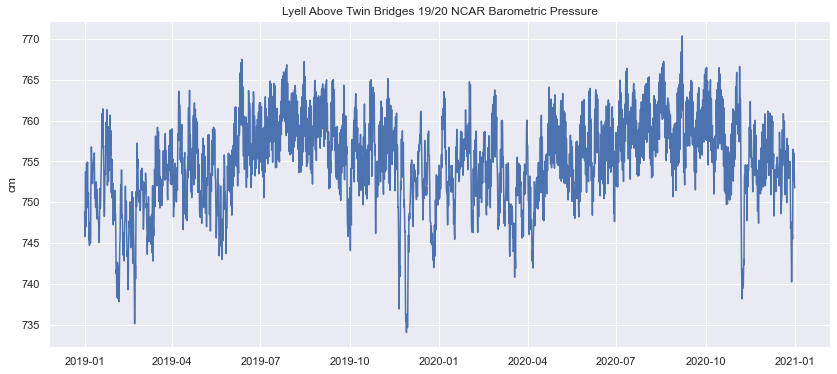

In [17]:
level_baro_utils.plot_ncar_baro(baro_df, site_info)

## Interpolate Level and Baro to Same Time Stamps
**Analyst TODO**: Inspect plot.

In [18]:
spanning_index = level_baro_utils.get_30min_spanning_index(level_trim_df)
level_interp_df = level_baro_utils.interpolate_to_timeseries(spanning_index, level_trim_df)
baro_interp_df = level_baro_utils.interpolate_to_timeseries(spanning_index, baro_df)

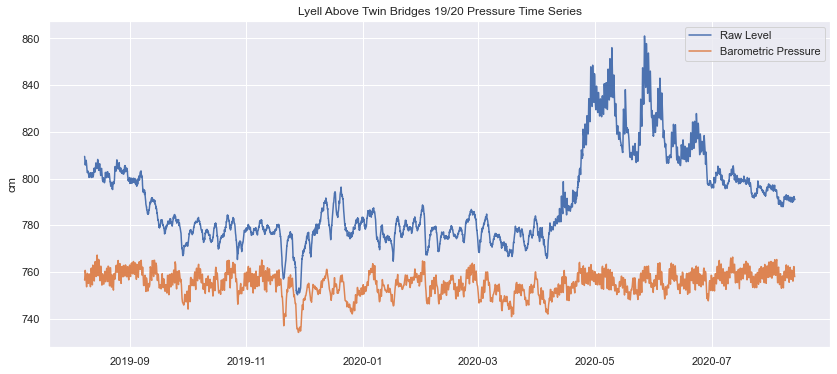

In [19]:
series = [level_interp_df['lvl_cm'], baro_interp_df['baro_cm']]
labels = ['Raw Level', 'Barometric Pressure']
level_baro_utils.plot_multiple_pres_timeseries(series, labels, site_info)

## Barocorrect Level Data
**Analyst TODO**: Inspect plots. Barocorrected level should be considerably smoother at large time scales than before. There should be clean diurnal swings in pressure as well. 

In [20]:
level_trimed_aligned_barocorrected_ds = level_baro_utils.barocorrect_level(level_interp_df, baro_interp_df)

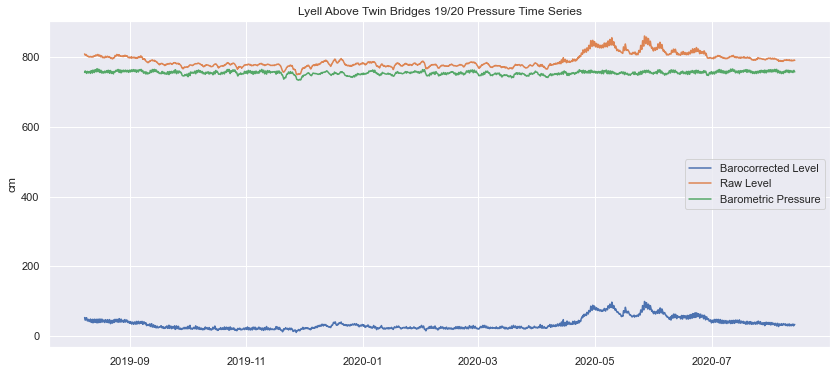

In [21]:
series = [level_trimed_aligned_barocorrected_ds, level_interp_df['lvl_cm'], baro_interp_df['baro_cm']]
labels = ['Barocorrected Level', 'Raw Level', 'Barometric Pressure']
level_baro_utils.plot_multiple_pres_timeseries(series, labels, site_info)

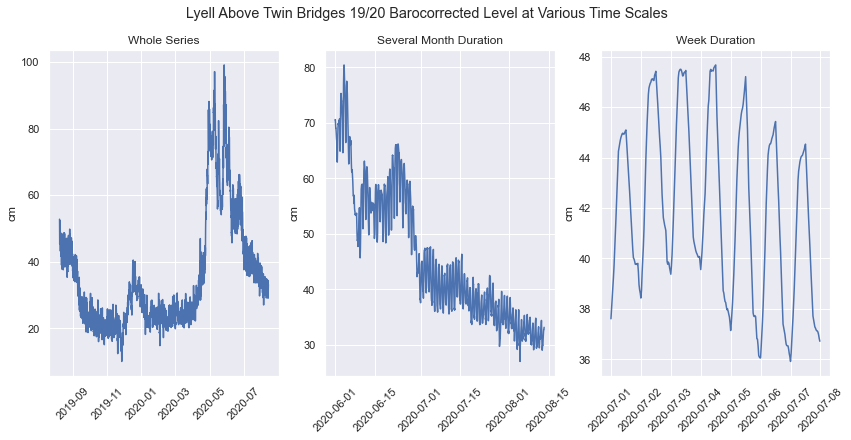

In [22]:
level_baro_utils.plot_pres_multiple_interval(level_trimed_aligned_barocorrected_ds,
                            'Barocorrected Level', 
                            site_info)

## Flag Ice Jams, Split Series When Sensor Shifts
**Analyst TODO**: Inspect all potential ice jams and sensor shifts. After all jams/shifts have been evaluated, add confirmed ice jams and sensor shifts to the appropriate list. 
1. For each ice jam/sensor shift candidate, create a new cell and encode the start and end date of the candidate. For example:
```
candidate_1 = {'start':'2018-12-1', 'end':'2018-12-6'}
level_baro_utils.plot_candidate(level_trimed_aligned_barocorrected_ds, candidate_1, site_info)
```
2. Ensure each candidate variable is numbered and that all numbers are unique (easiest to just have ascending numbers for each candidate)
3. Ensure the correct candidate is being passed to `level_baro_utils.plot_candidate` (i.e. after copying and pasting code into new cell, update the candidate number in both lines of code).
4. Run the cell and nspect the resultant plot.
5. If the candidate is determined to be an ice jam or sensor shift, add the candidate name to the approprioate list at the end of the section. If after evaluating all candidates there are no ice jams or sensor_shifts, assign a `None` to the appropriate variabel: e.g.:
```
ice_jams = [candidate_1]  # there is one ice jam
sensor_shifts = None      # there are no sensor shifts
```
6. **Important**: After deciding whether a segment is an ice jam or sensor shift, make a new Markdown cell below the cells and write record what the decision was and why (along with the date). Also note whether it was verified by Jessica or someone else with lots of domain knowledge/experience. 

In [23]:
ice_jams = None
sensor_shifts = None

## Create New Frame With All Desired Output Variables
**Analyst TODO**: Ensure tabular data has correct header fields. 

In [24]:
output_df = level_baro_utils.make_output_df(level_interp_df.index, 
                                            level_interp_df['lvl_cm'],
                                            level_trimed_aligned_barocorrected_ds,
                                            level_interp_df['temp_C'],
                                            ice_jams)

In [25]:
output_df.head()

,raw_pressure(cm),barocorrected_pressure(cm),water_temperature(deg_C),discharge_flag
date_time(UTC:PDT+7),,,,
2019-08-08 10:30:00,809.500000,52.754822,11.066000,0
2019-08-08 11:00:00,809.439911,52.774485,11.060916,0
2019-08-08 11:30:00,809.356133,52.770460,11.050840,0
2019-08-08 12:00:00,809.256800,52.750880,11.044151,0
2019-08-08 12:30:00,808.933511,52.079604,11.044773,0


## Split Series at Sensor Shifts and Save Data
**Analyst TODO**: Make sure the number of segments is consistent with the number of sensor shifts defined above.

In [26]:
output_dfs = level_baro_utils.split_series_at_shifts(output_df, sensor_shifts)
print(f'Number of segments: {len(output_dfs)}')

Number of segments: 1


## Save Output Data
**Analyst TODO**: Verify correct number of output files and verify file names and paths

In [27]:
level_baro_utils.save_barocorrected_timeseries(output_dfs, site_info)

Wrote segment 0 to ../data/barocorrected/LyellAbvTB_2020_barocorrected_0.csv


## Write Summary to Processing Log When Done
**Analyst TODO**: 
* Once done processing the site, assign `True` to `done` and run cell
* After writing to log, assign `True` to `wrote_to_log`

In [28]:
summary = level_baro_utils.get_summary(level_path, 
                                      utc_note, 
                                      baro_path, 
                                      ice_jams, 
                                      sensor_shifts)

In [31]:
done = True
wrote_to_log = True
if done and not wrote_to_log:
    log_fn = os.path.join('..', 'logs', f'{config.SITE_SHORTNAME[sitecode]}_{collection_year}_log.txt')
    log_utils.append_to_log(log_fn, 'SOLINST LEVEL POST PROCESSING AND QC', summary)